# 1. 介绍

前面我们将预测结果储存了起来，这里我们就可以进行使用了。在本课，我们将会把全部的框“切割”出来，储存为单独的文件，这些新的图像可以作为更复杂的训练的基础，比如说，用深度学习来评估根管治疗的效果，这时候使用原图会加大网络的负担，增加训练时间，因为首先网络就需要找到根管，才能进行学习如何进行评估。我们可以人为地将这个任务分成两步，首先将根管找到，然后切割成新的许多图像，这时候再去评价打分，就可以让网络的学习轻松很多。

In [6]:
import os

import torch
import numpy as np
import pandas as pd

from retinanet import model, val
from PIL import Image
import PIL
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline

# 2. 初始化
初始化参数，虽然有些用不到，不过保持和前面的notebooks一致就可以，不需要单独删掉，没有必要。

这里 scale 需要单独解释一下，即我们的预测结果有时候框比较小，这时候有些边缘部分无法被切下来，这时候我们选择将框放大一些，这样就可以保证没有遗漏的部分。

In [7]:
# consts
root_path = './data'
img_path = "./data/JPEGImages"
result_path = './result'
model_name = "root_treatment"

max_detections = 4
num_classes = 2
score_threshold = 0.5

scale = 1.2

detection = "{}_{}".format(
            model_name,
            score_threshold,
        )

选择加载的数据。最终切出来的图片将储存到对应的result_path。这里我们选择的是evaluate里面的预测结果，因为他是在原图上画出来的。

In [8]:
# get the result path from detection 
img_pd = pd.read_csv(os.path.join(result_path, detection + ".csv"))
crop_result_path = os.path.join(result_path, "detection_crop")
if not os.path.exists(crop_result_path):
     os.makedirs(crop_result_path)

# 3. 观察

尽管之前我们已经看过标注结果了，但是在这里还是选择一部分数据观察标注效果。这里的作画函数也是和前面差不多的。

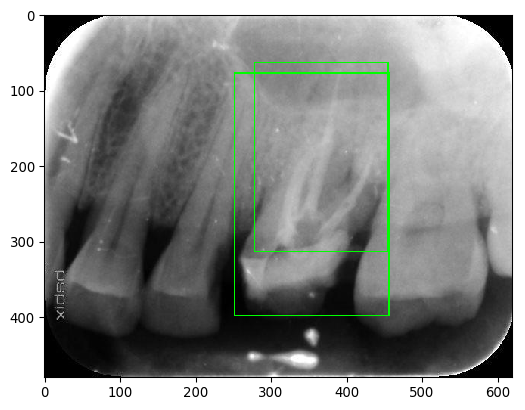

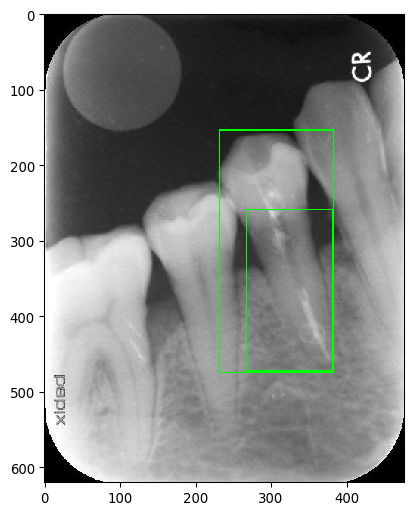

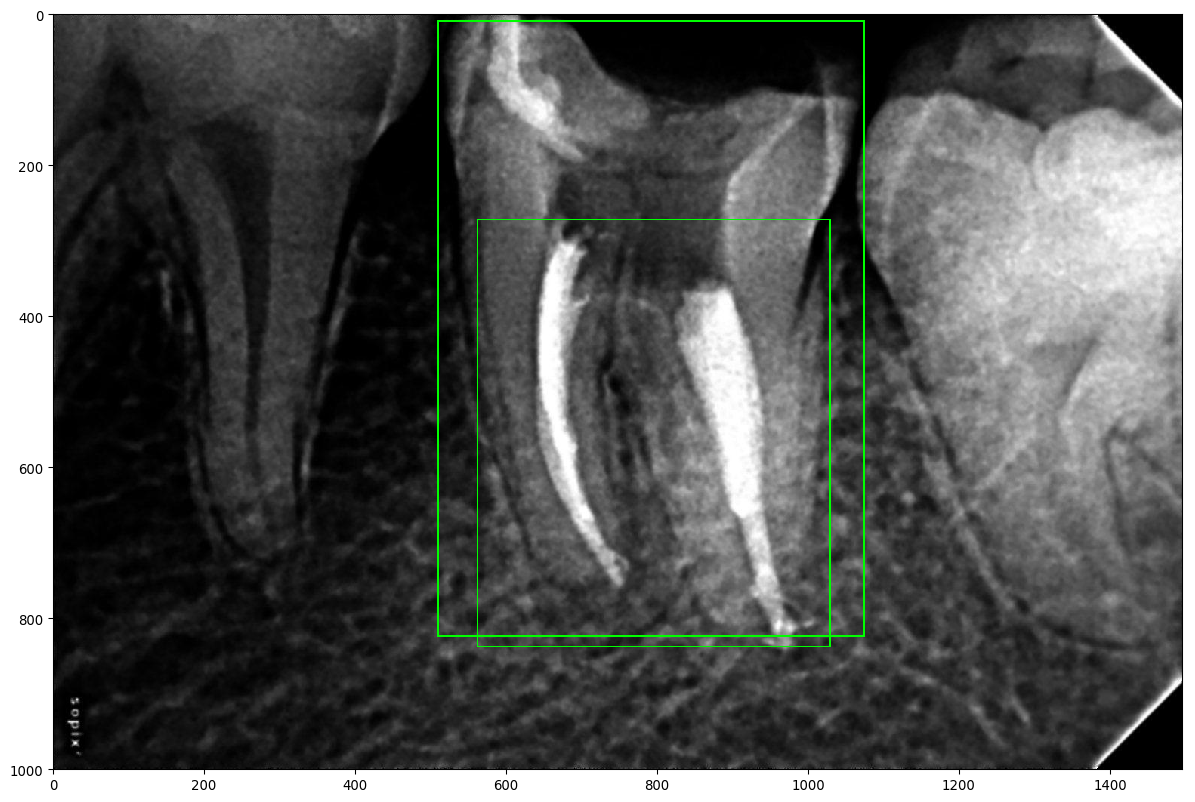

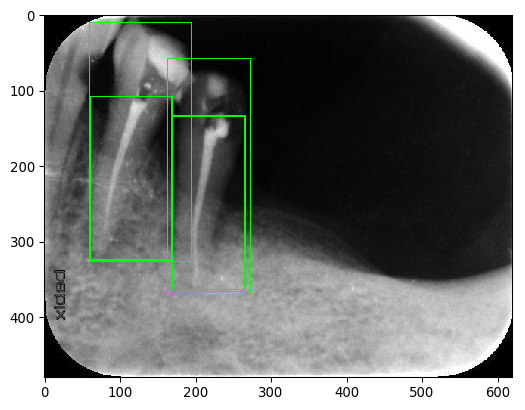

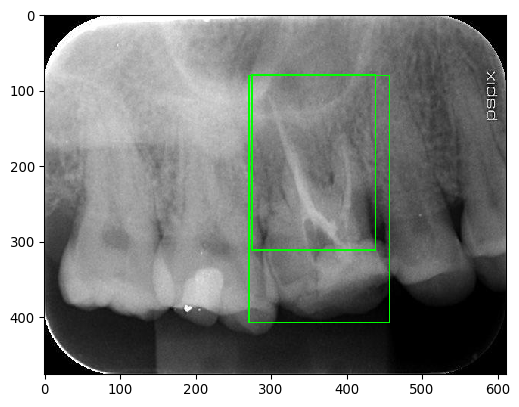

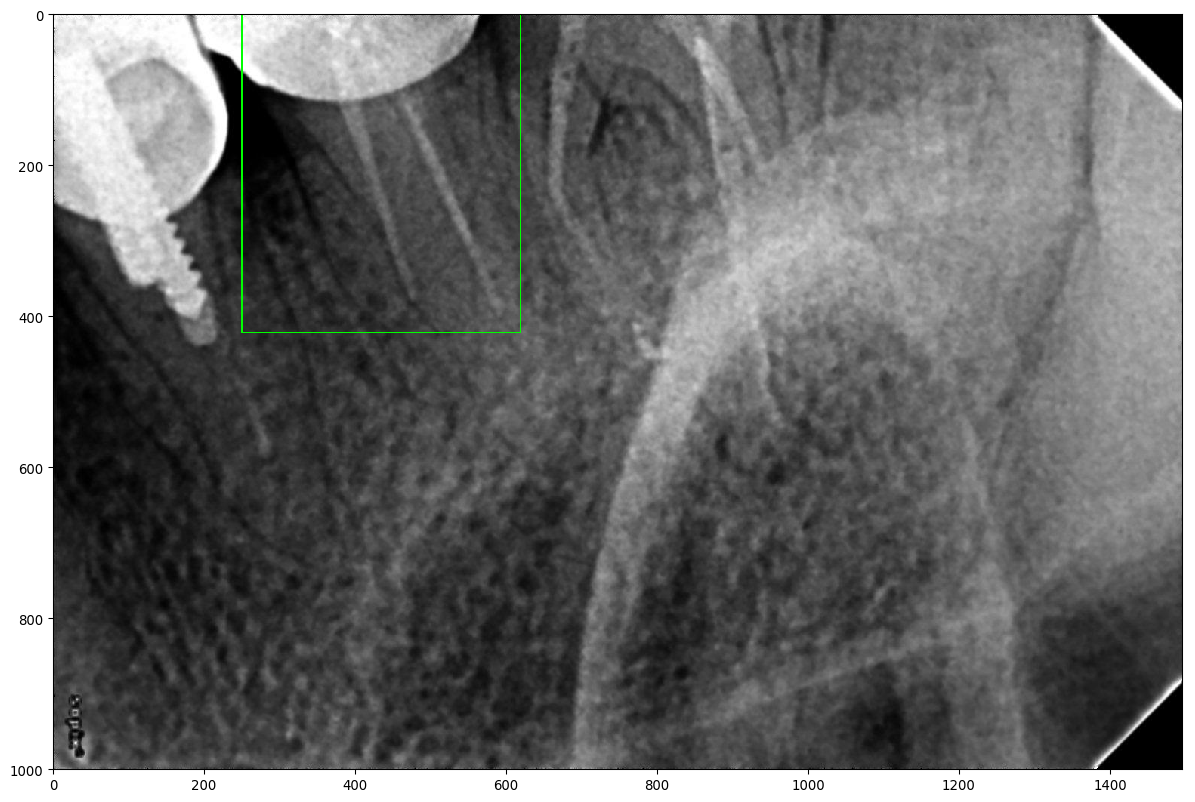

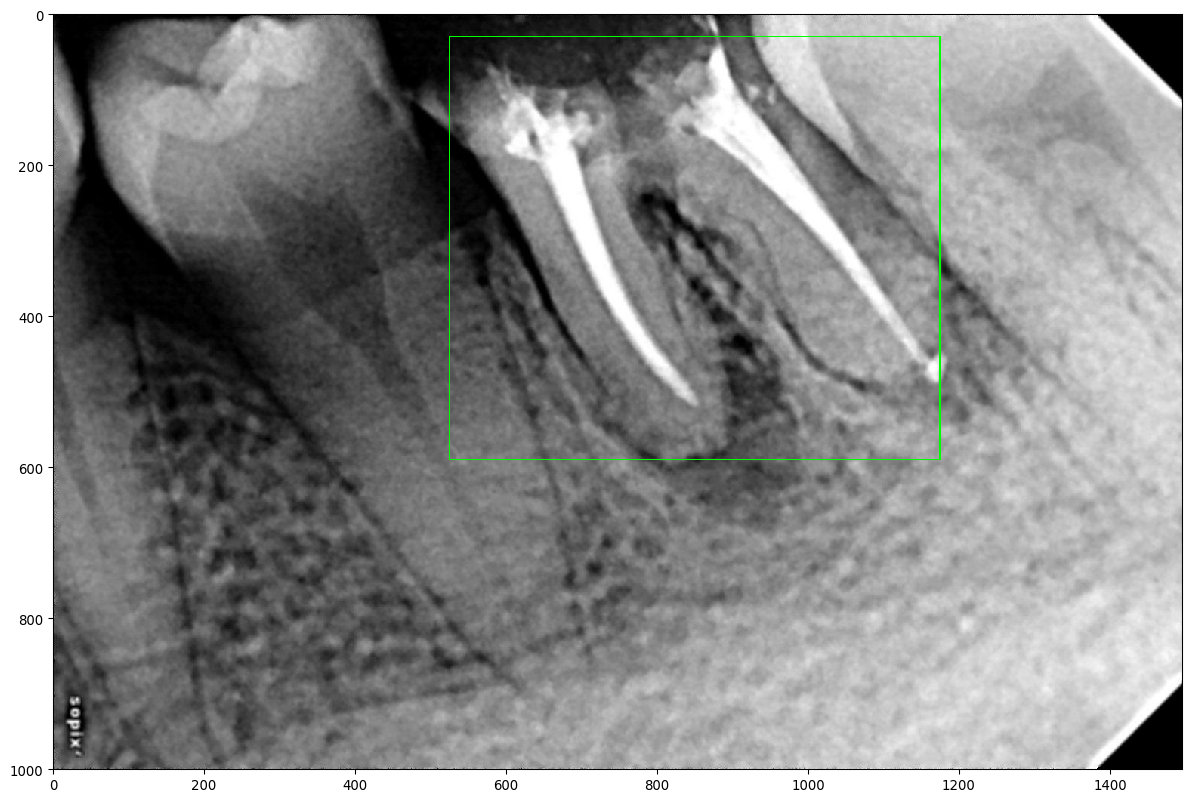

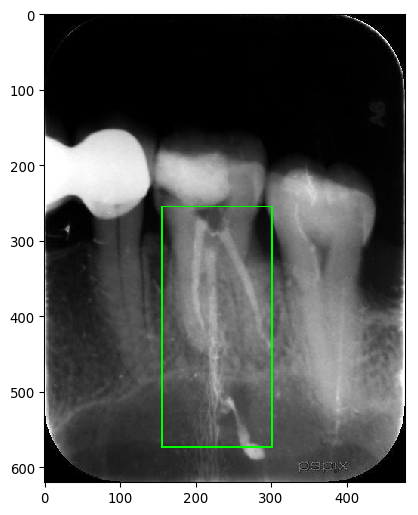

In [9]:
def draw_box(img_pd, img_path=None):
    # 这里直接取全部的图像名字
    name_series = img_pd.drop_duplicates(subset='id', inplace=False)['id']
    
    for image_name in name_series:
        img_some = img_pd[img_pd['id'] == image_name]
        
        # 当你需要显示两种label的时候，注释掉下面这一行
        # img_some = img_some[img_some['class'] == 0]
        
        img = Image.open(os.path.join(img_path, image_name + ".jpg"))
        np_img = np.asarray(img)
        # draw all box on the selected image
        for index in range(img_some.shape[0]):
            img_detect = img_some.iloc[index]
        
            x1 = img_detect['x1']
            y1 = img_detect['y1']
            x2 = img_detect['x2']
            y2 = img_detect['y2']
            bbs = []
            bbs.append(BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2))
            bbs_on_img = BoundingBoxesOnImage(bbs, shape=np_img.shape)
            np_img = bbs_on_img.draw_on_image(np_img, size=2, color=[0, 255, 0])
        
        ia.imshow(np_img)

# 只显示了一部分，看看效果即可
draw_box(img_pd[0:15], img_path=img_path)

# 4. 切割并保存

下面，我们针对图像，根据dataframe的数据进行切割，将结果保存到crop_result_path种。其中，框会以中心扩大scale倍。

In [10]:
def save_crop_box(img_pd, img_path=None, result_path=None, scale=1):
    # crop box on images which under img_path, and save under result_path, following img_pd's guide.
    #  Scale control the size ratio between new and old images.
    for index in range(img_pd.shape[0]):
        img = img_pd.iloc[index]
        
        uid = img['id']
        serial = img['serial']
        x1 = img['x1']
        y1 = img['y1']
        x2 = img['x2']
        y2 = img['y2']
        
        # 框的放大算法
        deltaw = (x2 - x1) * (scale - 1) / 2
        x1 -= deltaw
        x2 += deltaw
        deltah = (y2 - y1) * (scale - 1) / 2
        y1 -= deltah
        y2 += deltah
        
        # 打开图像
        img = Image.open(os.path.join(img_path, uid + ".jpg"))
        
        # box – 将要被切割的矩形，结构是(left, upper, right, lower)，最终切出来命名为 图像名称 + 标签名 
        box = (x1, y1, x2, y2)
        file_name = os.path.join(result_path, '{}_{}.jpg'.format(uid, serial))
        
        box = img.crop(box).save(file_name)

In [11]:
save_crop_box(img_pd[:], img_path=img_path, result_path=crop_result_path, scale=scale)